In [ ]:
# pip install opencv-python
# pip install tessaract

# Link para descargar el ejecutable de tesseract: https://github.com/UB-Mannheim/tesseract/wiki

In [3]:
import pandas as pd
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
import warnings
warnings.filterwarnings('ignore')
import os
os.getcwd()

'c:\\Users\\laura\\OneDrive - Universidad Politécnica de Madrid\\ABC_upm\\VSC\\Information_retrieval\\Assignment2'

# 1. Load Images

In [4]:
def get_images_paths(folder_path, df, n = 200):
    """
    Function to get the paths of the images in a folder and store them in a DataFrame
    
    :param folder_path: path of the folder where the images are stored
    :param df: DataFrame where the paths will be stored
    :param n: number of images to get | default = 200
    
    :return: DataFrame with the paths of the images
    """
    i = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                id = len(df)
                path = os.path.join(root, file)
                df.loc[id] = [id, path]
                i += 1
                if i == n:
                    break
    return df
                


In [5]:
# DataFrame: car_id, path

cars_df = pd.DataFrame(columns=['car_id', 'path'])
cars_df = get_images_paths("..\data\Formula_one_cars\Alphatauri", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Ferrari", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Mclaren", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Mercedes", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Racingpoint", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Redbull", cars_df)
cars_df = get_images_paths("..\data\Formula_one_cars\Renault", cars_df,400)
cars_df = get_images_paths("..\data\Formula_one_cars\Williams", cars_df)
print(cars_df.shape)
cars_df.tail()

(240, 2)


,car_id,path
235,235,..\data\Formula_one_cars\Williams\00000449.jpg
236,236,..\data\Formula_one_cars\Williams\00000459.jpg
237,237,..\data\Formula_one_cars\Williams\00000499.jpg
238,238,..\data\Formula_one_cars\Williams\00000514.jpg
239,239,..\data\Formula_one_cars\Williams\00000524.jpg


In [6]:
# save df as csv
cars_df.to_csv('cars.csv', index=False)

# 2. Plot _my_image_

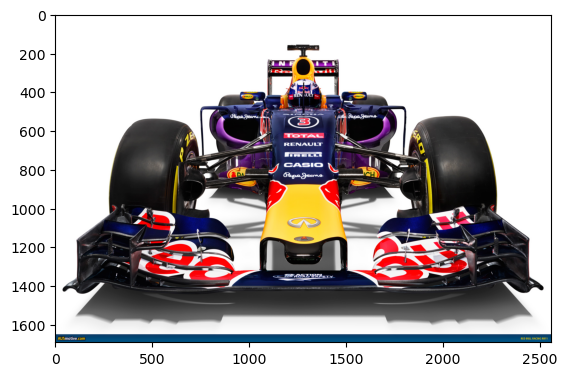

In [19]:
from PIL import Image
import matplotlib.pyplot as plt


# Our query image will be the 1033 image in the DataFrame (Alphatauri)
my_img_path = cars_df['path'][182]
my_img = Image.open(my_img_path)
plt.imshow(my_img)


# 3. Get some descriptors: Text (OCR - pytesseract) and Color (Histogram - cv2)

In [24]:
import pytesseract
import re
def ocr(path):
    """
    Function to perform OCR on an image. 
    It removes non-alphanumeric characters and returns a list of words in the image.
    
    Args:
    path: str, path to the image
    """
    img = Image.open(path)
    text = pytesseract.image_to_string(img, lang='eng')
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = text.split()
    return text

text = ocr(my_img_path)
print('words found in my_img: ',text)

words found in my_img:  ['ausmotivecom', 'red', 'bull', 'racing', 'rb11']


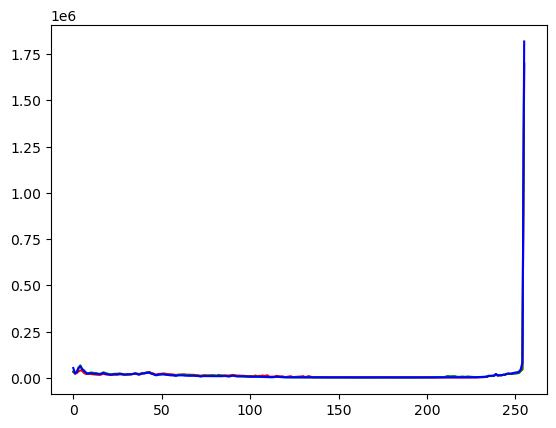

In [53]:
import cv2
my_image = cv2.imread(my_img_path)

# calculate the red channel histogram
red_hist = cv2.calcHist([my_image], [0], None, [256], [0, 256])
green_hist = cv2.calcHist([my_image], [1], None, [256], [0, 256])
blue_hist = cv2.calcHist([my_image], [2], None, [256], [0, 256])

#plot the histogram
plt.plot(red_hist, color='red')
plt.plot(green_hist, color='green')
plt.plot(blue_hist, color='blue')


# plt.ylim([0, 500000])
# plt.show()

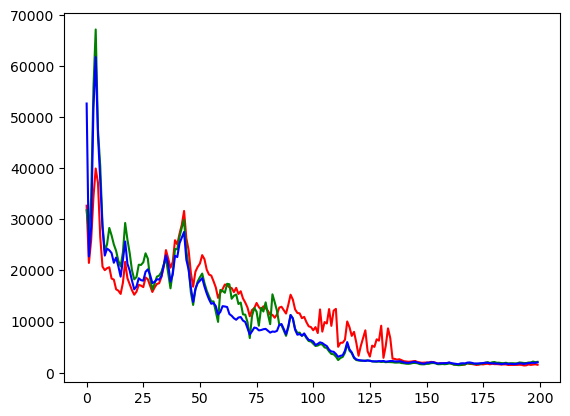

In [52]:
import cv2
my_image = cv2.imread(my_img_path)

# calculate the red channel histogram
red_hist = cv2.calcHist([my_image], [0], None, [256], [0, 256])
green_hist = cv2.calcHist([my_image], [1], None, [256], [0, 256])
blue_hist = cv2.calcHist([my_image], [2], None, [256], [0, 256])

# # filter white color
# mask = cv2.inRange(my_image, (0,0,0), (200, 200, 200))
# white = cv2.bitwise_and(my_image, my_image, mask=mask)
# plt.imshow(white)

# use only the first 200 values of

#plot the histogram
plt.plot(red_hist[0:200], color='red')
plt.plot(green_hist[0:200], color='green')
plt.plot(blue_hist[0:200], color='blue')


# plt.ylim([0, 500000])
# plt.show()

In [51]:
red_hist.shape

(256, 1)

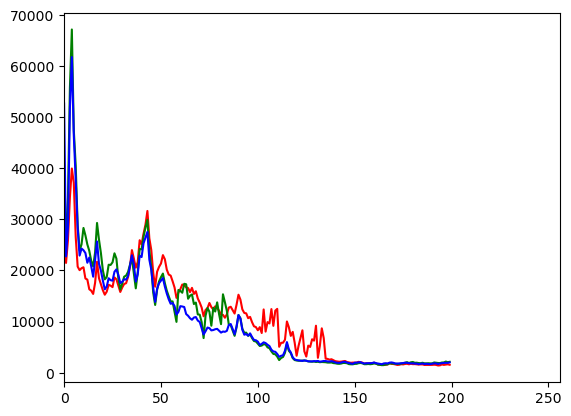

In [68]:
import cv2
my_image = cv2.imread(my_img_path)
def img_hist(image):
    """
    Function to plot the histogram of an image
    
    Args:
    image: image to plot the histogram
    """
    color = ('r', 'g', 'b')
    histogram = []
    for i, col in enumerate(color):
        color_hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        histogram.append(color_hist[0:200]) # use only the first 200 values of the histogram to avoid the white color
        plt.plot(color_hist[0:200], color = col)
        plt.xlim([0, 256])
    plt.show()
    return histogram

histogram = img_hist(my_image)


# 3. Perform OCR and Color Histogram on the image set

__OCR__: Se utiliza la librería de python "pytesseract". Se eliminan caractéres no alfabéticos, se pone todo en minúscula y se realiza un split de las palabras encontradas. Se hará un recuento de las veces que una de las palabras (o secuencia de caracteres) de la imagen de referencia se encuentra en una de las palabras (o secuencias de letras) de cada imágen del set. Este valor se pondera por 0.4.

__Color Histogram__: Se calcula el histograma de colores de cada imagen del set y la de referencia y se calcula la correlación y la intersección promedio entre los valores RGB de ambas. Tendrán una ponderación de 0.4 y 0.2 respectivamente.

 * cv2.HISTCMP_CORREL is a constant used in the OpenCV library for histogram comparison. It stands for correlation and is one of the methods to compare histograms. Specifically, it calculates the correlation between two histograms. The value returned by this method ranges from -1 to 1, where 1 indicates a perfect match (identical histograms), 0 indicates no correlation, and -1 indicates complete dissimilarity.

Here’s how it works mathematically:

Given two histograms H1 and H2, the correlation is calculated as:

[ \text{correlation} = \frac{\sum_i (H1[i] - \bar{H1}) \cdot (H2[i] - \bar{H2})}{\sqrt{\sum_i (H1[i] - \bar{H1})^2 \cdot \sum_i (H2[i] - \bar{H2})^2}} ]

Where:

(H1[i]) and (H2[i]) represent the bin values of the histograms at index (i).
(\bar{H1}) and (\bar{H2}) are the mean values of histograms H1 and H2, respectively.
In practical terms, a higher correlation value indicates greater similarity between the histograms. It’s commonly used for tasks like image matching, template matching, and object recognition.

* cv2.HISTCMP_INTERSECT: In the ImageComparator class, the intersection method is used (with flag CV_COMP_INTERSECT). This method simply compares, for each bin, the two values in each histogram, and keeps the minimum one. The similarity measure is then simply the sum of these minimum values. Consequently, two images having histograms with no colors in common would get an intersection value of 0, while two identical histograms would get a value equal to the total number of pixels.

__NOTA:__ Deberíamos buscar algún paper donde realicen esto de la intersección y la correlación para ponerlo en el documento como referencia. Y explicar un poco que significa cada uno.

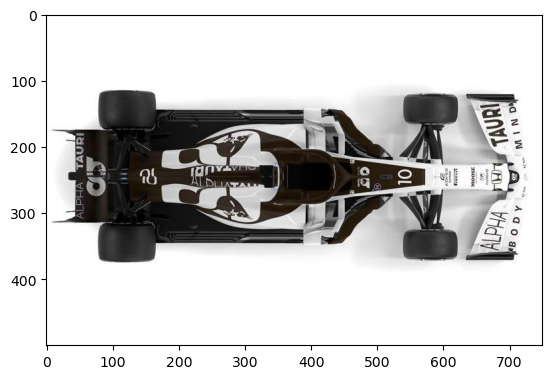

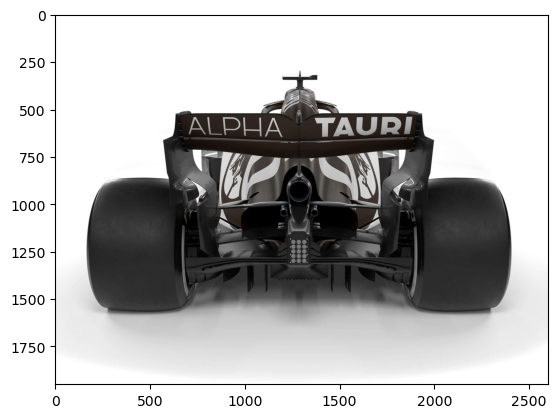

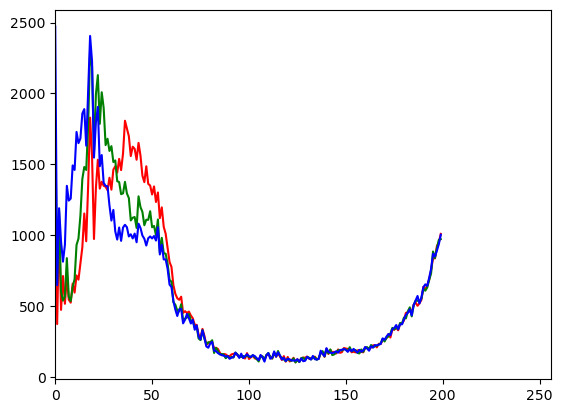

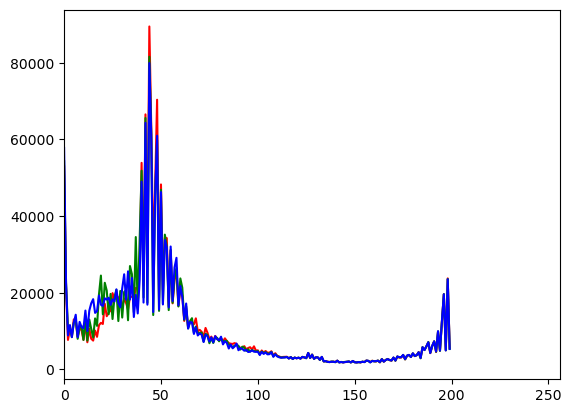

correlation:  0.6295744070327447
intersection:  -112951.66666666667


In [74]:
img1 = cv2.imread(cars_df['path'][0])
img2 = cv2.imread(cars_df['path'][1])

# show imgs
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# histogram 1
hist1 = img_hist(img1)
hist2 = img_hist(img2)

# compare histograms with correlation and intersection
correlation_r = cv2.compareHist(hist1[0], hist2[0], cv2.HISTCMP_CORREL)
intersection_r = cv2.compareHist(hist1[0], hist2[0], cv2.HISTCMP_INTERSECT)
correlation_g = cv2.compareHist(hist1[1], hist2[1], cv2.HISTCMP_CORREL)
intersection_g = cv2.compareHist(hist1[1], hist2[1], cv2.HISTCMP_INTERSECT)
correlation_g = cv2.compareHist(hist1[2], hist2[2], cv2.HISTCMP_CORREL)
intersection_g = cv2.compareHist(hist1[2], hist2[2], cv2.HISTCMP_INTERSECT)
mean_corr = (correlation_r + correlation_g + correlation_g) / 3
mean_int = -(intersection_r + intersection_g + intersection_g) / 3
print('correlation: ', mean_corr)
print('intersection: ', mean_int)



In [79]:
results = []
# iter over the df
for i, img in cars_df.iterrows():
    image = cv2.imread(img['path'])
    if my_img_path != img['path']:
        
        # Compare text between my_img and image
        text1 = ocr(my_img_path)
        text2 = ocr(img['path'])        
        
        # count number of equal words
        count = 0
        for word in text1:
            for w in text:
                if w in word or word in w:
                    count += 1
                
        if len(text1) == 0 or len(text2) == 0:
            similarity_txt = 0
        else:
            similarity_txt = count / len(text1)
        
        # Color comparison
        my_img = cv2.imread(my_img_path)
        blue1 = cv2.calcHist([my_img], [0], None, [256], [0, 256])
        green1 = cv2.calcHist([my_img], [1], None, [256], [0, 256])
        red1 = cv2.calcHist([my_img], [2], None, [256], [0, 256])
        
        blue2 = cv2.calcHist([image], [0], None, [256], [0, 256])
        green2 = cv2.calcHist([image], [1], None, [256], [0, 256])
        red2 = cv2.calcHist([image], [2], None, [256], [0, 256])
        
        # Compare histograms - correlation
        similarity_blue = cv2.compareHist(blue1, blue2, cv2.HISTCMP_CORREL)
        similarity_green = cv2.compareHist(green1, green2, cv2.HISTCMP_CORREL)
        similarity_red = cv2.compareHist(red1, red2, cv2.HISTCMP_CORREL)
        mean_corr = (similarity_blue + similarity_green + similarity_red) / 3
        
        # Compare histograms - intersection
        similarity_blue_i = cv2.compareHist(blue1, blue2, cv2.HISTCMP_INTERSECT)
        similarity_green_i = cv2.compareHist(green1, green2, cv2.HISTCMP_INTERSECT)
        similarity_red_i = cv2.compareHist(red1, red2, cv2.HISTCMP_INTERSECT)
        mean_intersection = -(similarity_blue_i + similarity_green_i + similarity_red_i) / 3
        
       # results.append([img['path'],0.4*similarity_txt+0.4* mean_corr+0.2*mean_intersection])
        results.append([img['path'],0.5*similarity_txt+0.5* mean_corr])
    

In [80]:
# results to df with two columns car_id, similarity
results_df = pd.DataFrame(results, columns=['path', 'similarity'])
results_df.tail()

,path,similarity
234,..\data\Formula_one_cars\Williams\00000449.jpg,0.494498
235,..\data\Formula_one_cars\Williams\00000459.jpg,-0.007748
236,..\data\Formula_one_cars\Williams\00000499.jpg,-0.001337
237,..\data\Formula_one_cars\Williams\00000514.jpg,-0.022465
238,..\data\Formula_one_cars\Williams\00000524.jpg,-0.024922


In [81]:

# sort df by similarity
results_df = results_df.sort_values(by='similarity', ascending=False)
results_df



,path,similarity
180,..\data\Formula_one_cars\Redbull\00000457.jpg,0.499070
71,..\data\Formula_one_cars\Mclaren\00000257.jpg,0.499026
160,..\data\Formula_one_cars\Redbull\00000181.jpg,0.498927
85,..\data\Formula_one_cars\Mclaren\00000382.jpg,0.498921
62,..\data\Formula_one_cars\Mclaren\00000151.jpg,0.498790
...,...,...
219,..\data\Formula_one_cars\Williams\00000102.jpg,-0.031842
229,..\data\Formula_one_cars\Williams\00000334.jpg,-0.032361
215,..\data\Formula_one_cars\Williams\00000052.jpg,-0.034859
226,..\data\Formula_one_cars\Williams\00000247.jpg,-0.036616


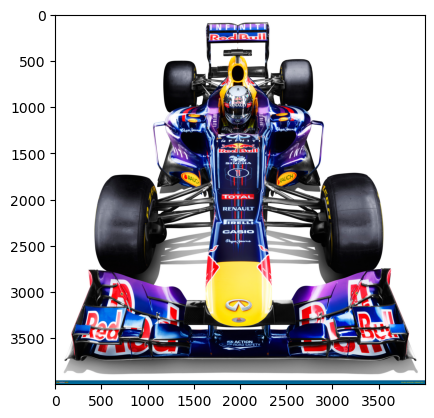

0.49907019556870585


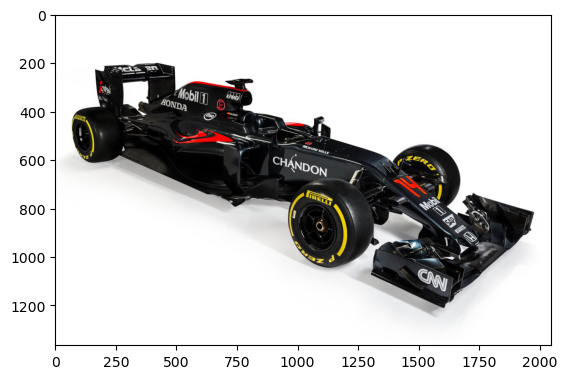

0.49902594211938234


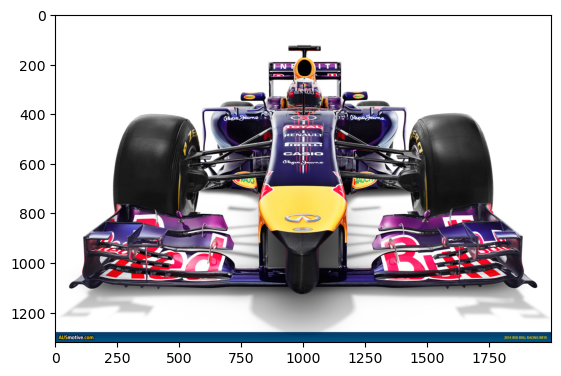

0.4989273945385222


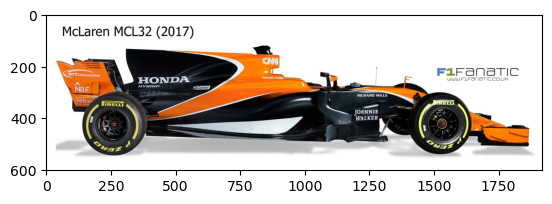

0.4989206292865221


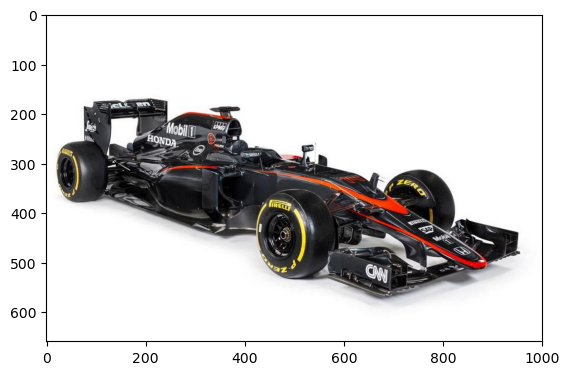

0.4987897457929161


In [82]:
# show first 5 images
for i, row in results_df.head().iterrows():
    img = Image.open(row['path'])
    plt.imshow(img)
    plt.show()
    print(row['similarity'])
    
# show last 5 images

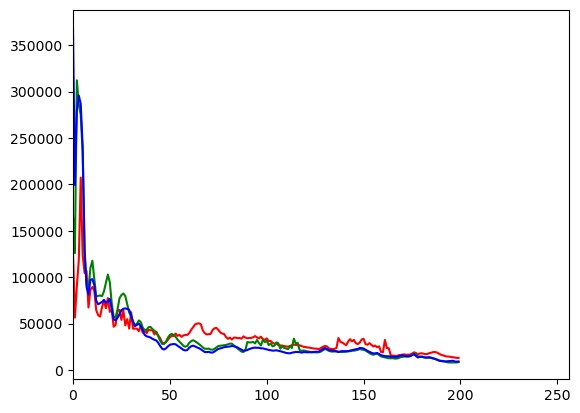

0.49907019556870585


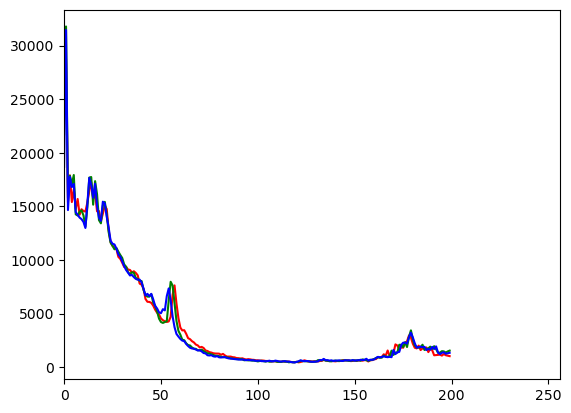

0.49902594211938234


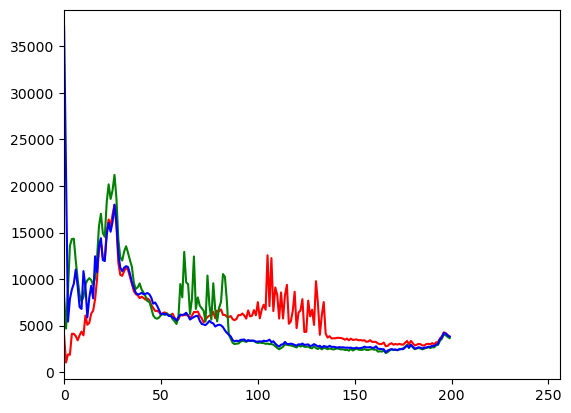

0.4989273945385222


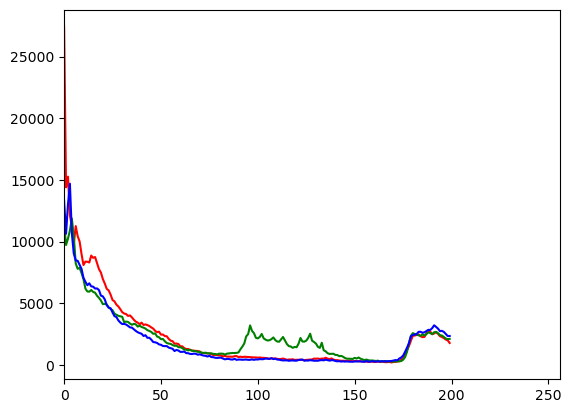

0.4989206292865221


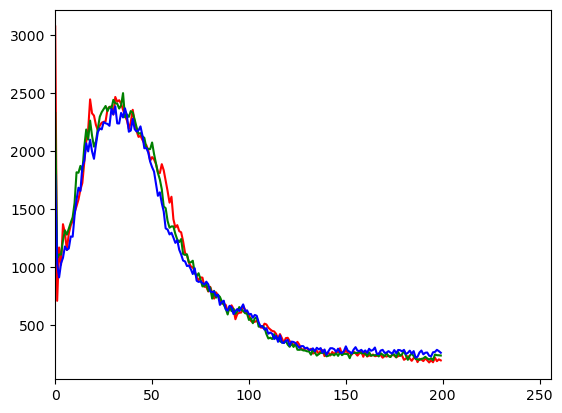

0.4987897457929161


In [83]:
# show first 5 images' histograms
for i, row in results_df.head().iterrows():
    img = cv2.imread(row['path'])
    img_hist(img)
    print(row['similarity'])
    


    
    

In [84]:
# print the text detected in the first image
for i in range(5):
    text = ocr(results_df['path'][i])
    print('words found in the first image: ',text)

words found in the first image:  ['a']
words found in the first image:  ['7', 'alpha', 'taupr']
words found in the first image:  []
words found in the first image:  []
words found in the first image:  []
